**32 x 32 Pixel Art Generator**

Yo this is the colab for https://github.com/zzbuzzard/pixartdiffusion, you can use it to generate some mediocre 32x32 pixel art. It's trained on sprites from [here](https://play.google.com/store/apps/details?id=com.zts.ageofstrategy) and [here](https://play.google.com/store/apps/details?id=com.zts.ageoffantasy).

To use it, set the parameters in the second box, then press Runtime -> Run All. After that, you can rerun just the second box.

In [ ]:
#@markdown #Setup - run once
#@markdown Clones repo + loads CLIP model
!git clone https://github.com/zzbuzzard/pixartdiffusion
!pip install ./pixartdiffusion
!pip install git+https://github.com/openai/CLIP.git

from google.colab import output
from pixartdiffusion import util, model, sample
import clip
from matplotlib import image
import torch
import os

os.makedirs("outputs/", exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load UNET model
model = model.UNet().to(device)
epoch = util.load_model(model, "pixartdiffusion/models/AOS_AOF.pt")
print("Loaded AOS_AOF model from epoch", epoch)

CLIP_MODEL = 'RN50' #@param ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14']

# Load CLIP
print("Loading CLIP model...")
clip_model, clip_preprocess = clip.load(CLIP_MODEL, device=device) # TODO: Support other models
# Art is scaled up by this amount before being fed to CLIP
assert clip_model.visual.input_resolution%32==0, "Input resolution must be divisible by 32... try another model."
clip_res_mul = clip_model.visual.input_resolution // 32

OUTPUT_NUM = 1

output.clear()

!nvidia-smi

print("Done")

Sun Apr  3 19:01:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |    779MiB / 11441MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Generating 4 * 4 * 8 = 128 samples...


 17%|█▋        | 83/490 [00:13<01:04,  6.27it/s]

ITERATION 407


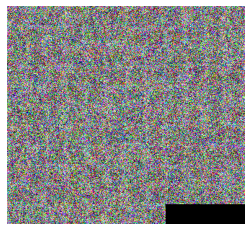

 50%|█████     | 246/490 [00:39<00:38,  6.27it/s]

ITERATION 244


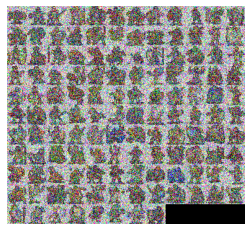

 83%|████████▎ | 409/490 [01:05<00:12,  6.31it/s]

ITERATION 81


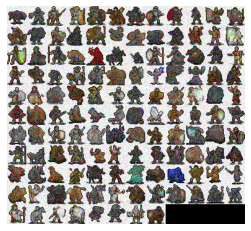

100%|██████████| 490/490 [01:18<00:00,  6.23it/s]


All samples (before CLIP re-ranking):


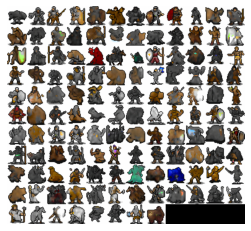

Your samples, sir:


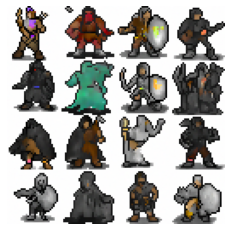

Output saved to outputs/output2.png


In [ ]:
#@markdown #Parameters

#@markdown \
#@markdown ### Main Parameters

#@markdown A spritesheet of given width and height (in terms of samples) will be generated. Note that this requires `sheet_width*sheet_height` total samples.
sheet_width = 4 #@param{type:"integer"}
sheet_height = 4 #@param{type:"integer"}

#@markdown The noise multiplier determines how much extra noise is added on during sampling. Higher values lead to more chaotic samples, lower values lead to featureless blobs. I recommend 6-10.
noise_mul = 7 #@param{type:"integer"}

#@markdown How many times to display the output during generation.
display_count = 3 #@param{type:"integer"}

#@markdown \
#@markdown ### CLIP Selection - I recommend u use this
#@markdown Generates lots of samples then selects the ones that match `selection_prompt` best using CLIP. If you are using CLIP Guidance as well, it would make sense to use the same prompt.
#@markdown Just using a generic prompt like 'pixel art' works ok!
selection_prompt = "cool colourful pixel art character #pixelart" #@param{type:"string"}

#@markdown How many samples are computed per output sample. For example, if `sheet_width=sheet_height=10` and `generation_multiplier=5`, then 500 samples will be computed, and the output will be the top 100 according to CLIP. Leave at 1 for no CLIP selection.
generation_multiplier =  8#@param{type:"integer"}

#@markdown \
#@markdown ### CLIP Guidance
#@markdown **I recommend against using CLIP guidance, it doesn't work that well and it takes way longer.** Might be worth a try if you have lots of compute though (I'm stuck with a K80, 4 samples takes ~10 minutes so I haven't experimented much).
use_clip_guidance = False #@param{type:"boolean"}
prompt = "a green octopus #pixelart" #@param{type:"string"}
#@markdown Number of times to shift the output and feed to CLIP. Higher values will take longer to compute, but in theory will be more true to the prompt.
shiftn = 8 #@param{type:"integer"}

#@markdown Multiplier for CLIP guidance. Higher values should 'look more like the prompt'. I didn't have the compute to test this properly - I think around 10k is reasonable, but I'm not sure.
classifier_mul = 10000 #@param{type:"integer"}

print(f"Generating {sheet_width} * {sheet_height} * {generation_multiplier} = {sheet_width * sheet_height * generation_multiplier} samples...")




### Do the run:

if use_clip_guidance:
    tokenized_text = clip.tokenize([prompt]).to(device)

    func = sample.clip_grad_func(clip_model, tokenized_text, num_shifts=shiftn, shift_range=clip_res_mul*2)
    xs = sample.sample(model, sheet_width * sheet_height * generation_multiplier, display_count=display_count, noise_mul=noise_mul, classifier_mul=classifier_mul, classifier_func=func)
else:
    xs = sample.sample(model, sheet_width * sheet_height * generation_multiplier, display_count=display_count, noise_mul=noise_mul)

# CLIP Re-rank
if generation_multiplier != 1:
    top_n = sheet_width * sheet_height
    tokenized_text = clip.tokenize([selection_prompt]).to(device)
    unfiltered_samples = xs
    xs = sample.CLIP_rerank(clip_model, xs, tokenized_text)[:top_n]

    print("All samples (before CLIP re-ranking):")
    all_sheet = util.to_drawable(unfiltered_samples, scale=4)
    util.draw_im(all_sheet)

sheet = util.to_drawable(xs, fix_width = sheet_width)
print("Your samples, sir:")
util.draw_im(sheet)

save_path = f"outputs/output{OUTPUT_NUM}.png"
image.imsave(save_path, sheet)
print("Output saved to",save_path)
OUTPUT_NUM += 1